# Price Data API

In [1]:
import pandas as pd
import requests
import re

from datetime import date
from io import StringIO

In [2]:
def date_yf(dt):
    return (dt - date(1969, 12, 31)).days * 86400

def encode_yf(symbol, date_start, date_stop, interval):
    period1 = date_yf(date_start)
    period2 = date_yf(date_stop)
    
    return re.sub(r"(\n|\t| )", "", f"""
    https://query1.finance.yahoo.com/v7/finance/download/{symbol}
    ?period1={period1}
    &period2={period2}
    &interval={interval}
    &events=history&includeAdjustedClose=true
    """)

def download_yf_prices(symbol, date_start, date_stop, interval):
    uri = encode_yf(symbol, date_start, date_stop, interval)
    resp = requests.get(uri)
    
    if resp.status_code != 200:
        return None
    
    data = StringIO(resp.content.decode('utf-8'))
    
    return pd.read_csv(data, sep=",")

_Usage_

```python
download_yf_prices("BND", date(2000, 4, 9), date(2021, 1, 2), "1wk")
```

# Download

In [3]:
import os
import time

# Note that vanguard's "CORE_ETFS" = ["BND", "BNDX", "VTI", "VXUS"]
DATE_START = date(1995, 1, 1)
DATE_END   = date(2021, 1, 2)
CACHE_DIR = os.path.join("prices", "Jan_1995_Jan_2021")

if not os.path.exists(CACHE_DIR):
    os.mkdir(CACHE_DIR)

vanguard = pd.read_csv("Vanguard_ETFs.csv")
vanguard.head(5)

,Category,Name,Symbol,Class,ER
0,Treasury/Agency,Extended Duration Treasury ETF,EDV,Bond - Long-term Government,0.07%
1,Treasury/Agency,Vanguard Select FundsIntermediate-Term Bond ETF,BIV,Bond - Inter-term Investment,0.05%
2,Treasury/Agency,Intermediate-Term Treasury ETF,VGIT,Bond - Inter-term Government,0.05%
3,Treasury/Agency,Vanguard Select FundsLong-Term Bond ETF,BLV,Bond - Long-term Investment,0.05%
4,Treasury/Agency,Long-Term Treasury ETF,VGLT,Bond - Long-term Government,0.05%


In [4]:
SYMBOLS = vanguard.Symbol.unique()

for symbol in SYMBOLS:
    fpath = os.path.join(CACHE_DIR, f"{symbol}.csv")
    if not os.path.exists(fpath):
        prices = download_yf_prices(symbol, DATE_START, DATE_END, "1wk")
        
        if not prices is None:
            prices.to_csv(fpath, index=False)
            time.sleep(1)
        else:
            print(f"{symbol} failed to download")

# Read

In [5]:
from dateutil import parser
import numpy as np

## Price Vector

In [6]:
price_vec = pd.DataFrame()
for f in os.listdir(CACHE_DIR):
    if os.path.isfile(os.path.join(CACHE_DIR, f)):
        temp = pd.read_csv(os.path.join(CACHE_DIR, f))
        temp = temp[['Date', 'Adj Close']].copy()
        temp['Symbol'] = os.path.splitext(f)[0]
        price_vec = pd.concat((price_vec, temp))
price_vec['Date'] = [parser.parse(x) for x in price_vec.Date]
price_vec.head()

,Date,Adj Close,Symbol
0,2010-09-20,46.145058,VONG
1,2010-09-27,45.987106,VONG
2,2010-10-04,46.899662,VONG
3,2010-10-11,47.847294,VONG
4,2010-10-18,48.101757,VONG


## Assign _Date_ a Week Index

In [7]:
weekly_dates = price_vec.Date.unique()
weekly_dates.sort()
weekly_index = [0]

prior_date = weekly_dates[0]
index = 0

for i in range(1, len(weekly_dates)):
    dt = (weekly_dates[i] - prior_date).astype('timedelta64[D]')/np.timedelta64(1, 'D')
    if dt >= 5:
        index += 1
        prior_date = weekly_dates[i]
    weekly_index.append(index)
    
week_idx = pd.DataFrame({'Date': weekly_dates, 'Week_Idx': weekly_index})
price_vec = price_vec.merge(week_idx, on='Date')
price_vec.head()

,Date,Adj Close,Symbol,Week_Idx
0,2010-09-20,46.145058,VONG,484
1,2010-09-20,33.291584,VGK,484
2,2010-09-20,33.883999,VWO,484
3,2010-09-20,27.021132,MGV,484
4,2010-09-20,46.465790,VTWO,484


## Read in Monthly 3-Mo T Bill Rates

In [8]:
# 3 month t bills
tbill = pd.read_csv(os.path.join("prices", "RFR.csv"))
tbill['DATE'] = tbill.DATE.apply(parser.parse)
tbill['YYYY_MM'] = tbill.DATE.apply(lambda d: f"{np.datetime64(d).astype('datetime64[M]').astype(str)}")
tbill['TB3MS'] = [0.0 if x == '.' else float(x) for x in tbill.TB3MS]
tbill['RFR'] = tbill.TB3MS.apply(lambda x: (1+x/100) ** (1/52) - 1)
tbill.drop(columns=['TB3MS'], inplace=True)
tbill = tbill.groupby('YYYY_MM').aggregate({'RFR': 'mean'}).reset_index()
tbill.head()

,YYYY_MM,RFR
0,1995-01,0.001068
1,1995-02,0.001079
2,1995-03,0.001072
3,1995-04,0.001058
4,1995-05,0.001061


## Weekly Index to Risk-Free Rate Lookup

In [9]:
weekly_yyyy_mm = [f"{d.astype('datetime64[M]').astype(str)}" for d in weekly_dates]
weekly_idx_rfr = pd.DataFrame({'Week_Idx': weekly_index, 'YYYY_MM': weekly_yyyy_mm})
weekly_idx_rfr = weekly_idx_rfr.merge(tbill[['YYYY_MM', 'RFR']], on='YYYY_MM', how='inner')
weekly_idx_rfr.drop(columns=['YYYY_MM'], inplace=True)
weekly_idx_rfr = weekly_idx_rfr.groupby('Week_Idx').aggregate({'RFR': 'mean'}).reset_index()
weekly_idx_rfr.head()

,Week_Idx,RFR
0,0,0.000660
1,1,0.000660
2,2,0.000660
3,3,0.000664
4,4,0.000664


In [10]:
weekly_idx_rfr.tail()

,Week_Idx,RFR
1012,1012,0.000017
1013,1013,0.000017
1014,1014,0.000017
1015,1015,0.000017
1016,1016,0.000017


## Convert Price Vector to Matrix

In [11]:
price_vec_agg = price_vec.groupby(['Week_Idx', 'Symbol']).aggregate({'Adj Close': 'mean'}).reset_index()
print(f"{price_vec.shape[0]} to {price_vec_agg.shape[0]}")

47879 to 47804


In [12]:
price_mat = price_vec_agg.pivot(index='Week_Idx', columns='Symbol', values='Adj Close')
price_mat.tail(10)

Symbol,BIV,BLV,BND,BNDW,BNDX,BSV,EDV,ESGV,IVOG,IVOO,...,VTWO,VTWV,VUG,VV,VWO,VWOB,VXF,VXUS,VYM,VYMI
Week_Idx,,,,,,,,,,,,,,,,,,,,,
1011,91.579056,105.948631,86.999901,81.285767,58.113106,82.519585,151.393082,60.332767,149.536697,127.857964,...,123.135170,89.730453,220.363846,151.939377,43.546425,77.523018,131.334930,50.471123,78.836342,50.174061
1012,92.043427,108.077469,87.436966,81.614578,58.192795,82.499664,154.210373,65.036613,161.318985,136.364578,...,131.498856,94.149452,240.217255,163.214798,46.588013,79.146744,141.197250,54.293343,82.563080,53.432503
1013,92.076904,107.755707,87.388969,81.546143,58.110115,82.576447,152.643066,65.853806,164.515198,142.244598,...,139.533951,102.709396,237.751785,166.043625,46.846451,80.272964,145.834808,56.016312,87.062904,56.492863
1014,92.482704,110.083679,87.946220,81.925247,58.339405,82.636292,156.969955,65.644524,166.818039,144.602570,...,142.620544,105.400513,236.923309,165.575470,47.611816,80.451782,151.169022,56.957012,87.072823,57.651638
1015,92.591576,109.967293,87.936272,81.945190,58.369312,82.686172,155.114212,67.398491,169.974548,148.492737,...,148.246109,109.958542,242.962189,169.818710,48.466640,80.670341,153.358444,58.105659,89.540794,59.087730
1016,92.076904,107.775116,87.438721,81.615974,58.209805,82.596397,149.085403,68.564491,172.654587,151.159134,...,151.432266,112.838333,246.545578,172.767044,49.043152,80.888908,158.881714,58.967144,91.255493,60.167274
1017,92.535942,109.347443,87.899200,82.110947,58.613766,82.798012,153.633453,68.026344,172.465988,150.980057,...,153.045273,112.659584,244.159973,171.253021,48.933815,81.339371,159.847046,58.719589,90.690529,60.028618
1018,92.555779,108.764153,87.809494,81.931168,58.414230,82.808006,150.873856,69.192337,177.329773,153.954895,...,156.609772,113.493736,251.117157,173.992188,49.729000,81.807869,165.479813,59.689999,90.750000,60.711998
1019,91.911369,106.275444,87.719795,81.961128,58.324440,82.758064,146.229660,69.580002,178.759140,155.377625,...,160.639999,115.680000,250.787766,173.235184,48.625679,81.807869,164.733429,58.779003,89.580437,59.830536


In [13]:
available_weeks = price_mat.shape[0] - price_mat.applymap(lambda x: pd.isna(x)).sum()
available_weeks

Symbol
BIV     717
BLV     717
BND     717
BNDW    122
BNDX    396
       ... 
VWOB    396
VXF     992
VXUS    519
VYM     738
VYMI    253
Length: 75, dtype: int64

# Analysis

In [14]:
from jax import grad, jit
import jax.numpy as jnp
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = 8, 5

In [16]:
MINIMUM_SAMPLE_SIZE = 52*10
samples = [i for i in range(len(available_weeks)) if available_weeks[i]>=MINIMUM_SAMPLE_SIZE]

X = price_mat.iloc[(price_mat.shape[0]-MINIMUM_SAMPLE_SIZE):price_mat.shape[0], samples].copy()
X.reset_index(inplace=True)
X = X[(X.Week_Idx >= weekly_idx_rfr.Week_Idx.min()) & (X.Week_Idx <= weekly_idx_rfr.Week_Idx.max())]
RFR = weekly_idx_rfr[weekly_idx_rfr.Week_Idx >= X.Week_Idx.min()]
X.drop(columns=['Week_Idx'], inplace=True)
assert X.shape[0] == RFR.shape[0], "RFR dimension mismtach"

In [17]:
# Comput constants

# Holding period return
H = X.values[1:X.shape[0]] / X.values[0:(X.shape[0]-1)] - 1

for j in range(H.shape[1]):
    H[:, j] -= RFR.RFR[1:RFR.shape[0]]

M, N = H.shape

# Mean returns
U = np.mean(H, axis=0).reshape((1,N))

# Covariance matrix
S = np.cov(H.transpose())

In [18]:
def wts(N):
    x = np.random.uniform(0, 1, (1, N))
    return x / x.sum()

@jit
def relu(x):
    return jnp.maximum(x, 0.0)

@jit
def port_var(w, s):
    return jnp.matmul(jnp.matmul(w, s), jnp.transpose(w))

@jit
def port_ret(w, u):
    return jnp.matmul(w, jnp.transpose(u))

@jit
def port_eff(w, u, s):
    return port_ret(w, u)/jnp.sqrt(port_var(w, s))

In [19]:
w = wts(N)
print(port_var(w, S))
print(port_ret(w, U))
print(port_eff(w, U, S))

[[0.00035698]]
[[0.00195333]]
[[0.10338363]]


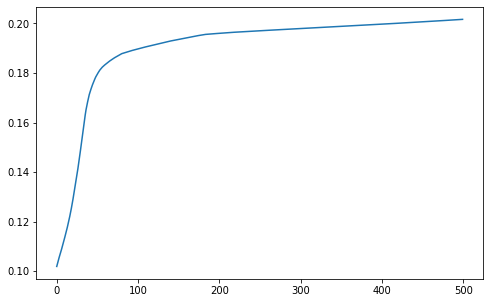

In [20]:
@jit
def inline_obj1(w):
    return jnp.sum(port_eff(w, U, S))

g = grad(inline_obj1)
w = wts(N)

epochs = 500
alpha = 0.01
objs = []

for epoch in range(epochs):
    w += alpha*g(w)
    w = relu(w)
    w = w / w.sum()
    o = inline_obj1(w)
    objs.append(o)

plt.plot(objs)

In [21]:
w

DeviceArray([[0.04478075, 0.        , 0.        , 0.05667604, 0.11704259,
              0.        , 0.        , 0.        , 0.        , 0.02515692,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.04604509, 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.15250094,
              0.        , 0.13088603, 0.08653789, 0.19062121, 0.07221104,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.05938021, 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.00405388, 0.        , 0.        , 0.01410742,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        ]], dtype=float32)